In [1]:
import torch
import clip
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import torch.nn.functional as F

In [2]:

# Choose device and CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "ViT-B/32"  # or "RN50"
model, preprocess = clip.load(model_name, device=device)


In [5]:
# process images and text prompts
# prepare input tensors

image_paths = ["cat.jpg", "dog.png", "giraffe.jpg"]

images = [preprocess(Image.open(p)) for p in image_paths]
image_input = torch.stack(images).to(device)


text_prompts = [
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a giraffe"
]


text_tokens = clip.tokenize(text_prompts).to(device)


print(f"Image tensor shape: {image_input.shape}")  # [batch_size, 3, 224, 224]
print(f"Text tokens shape: {text_tokens.shape}")  # [batch_size, context_length]




Image tensor shape: torch.Size([3, 3, 224, 224])
Text tokens shape: torch.Size([3, 77])


In [7]:
# 2. Encode image and text

print("\nEncoding images and text...")
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_tokens)

print(f"Raw image features shape: {image_features.shape}")  # [batch_size, feature_dim]
print(f"Raw text features shape: {text_features.shape}")  # [batch_size, feature_dim]

# Normalize embeddings (L2 normalization)
image_features = image_features / image_features.norm(dim=-1, keepdim=True)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

print(f"\nNormalized image features shape: {image_features.shape}")
print(f"Normalized text features shape: {text_features.shape}")

# Check vector shapes and confirm unit length
image_norms = image_features.norm(dim=-1)
text_norms = text_features.norm(dim=-1)

print(f"\nImage feature norms: {image_norms.cpu().numpy()}")
print(f"Text feature norms: {text_norms.cpu().numpy()}")
print("✓ All vectors have unit length (norm ≈ 1.0)")



Encoding images and text...
Raw image features shape: torch.Size([3, 512])
Raw text features shape: torch.Size([3, 512])

Normalized image features shape: torch.Size([3, 512])
Normalized text features shape: torch.Size([3, 512])

Image feature norms: [1. 1. 1.]
Text feature norms: [1.0000001  0.99999994 1.        ]
✓ All vectors have unit length (norm ≈ 1.0)



c. COMPUTING COSINE SIMILARITIES
Similarity Matrix:
Rows = Images, Columns = Text Prompts
a photo of a cat         a photo of a dog         a photo of a giraffe     
Image 1: 0.288      0.231      0.196      
Image 2: 0.199      0.276      0.196      
Image 3: 0.197      0.205      0.312      


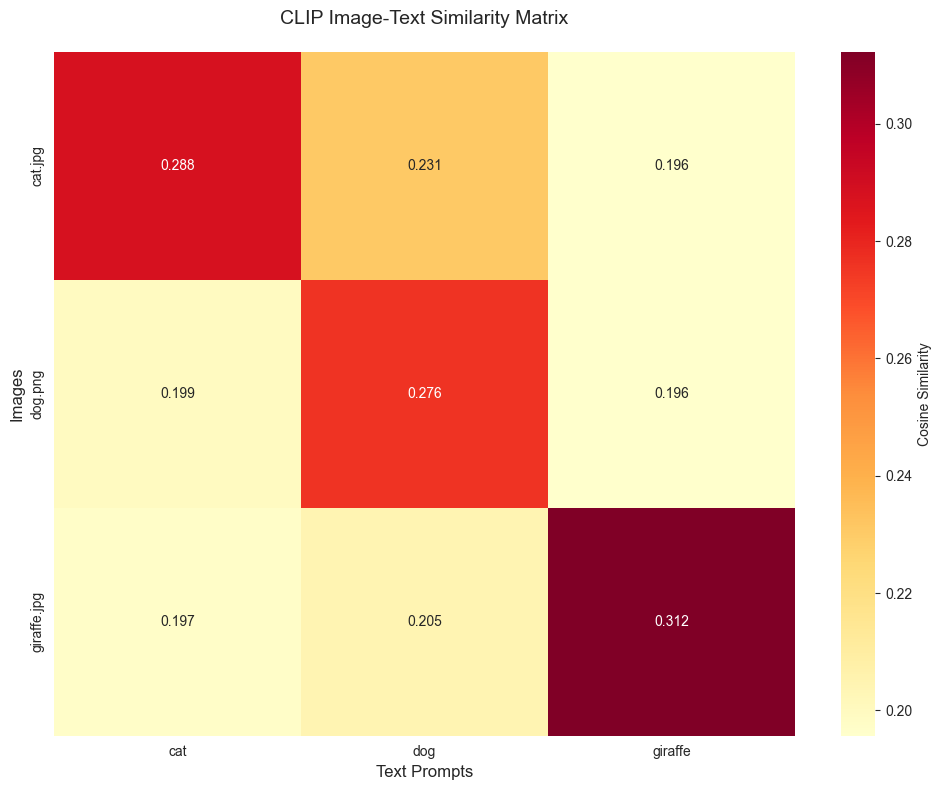

In [10]:
# compute cosine similarity


print("\n" + "=" * 50)
print("c. COMPUTING COSINE SIMILARITIES")
print("=" * 50)

# Compute similarity matrix
similarity_matrix = (image_features @ text_features.T).cpu().numpy()

print("Similarity Matrix:")
print("Rows = Images, Columns = Text Prompts")
print("=" * 60)
for i, prompt in enumerate(text_prompts):
    print(f"{prompt:25}", end="")
print()
for i in range(len(images)):
    print(f"Image {i + 1}:", end=" ")
    for j in range(len(text_prompts)):
        print(f"{similarity_matrix[i, j]:.3f}".ljust(10), end=" ")
    print()

# Visualize as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix,
            annot=True,
            fmt=".3f",
            xticklabels=[p.replace('a photo of a ', '') for p in text_prompts],
            yticklabels=image_paths,
            cmap="YlOrRd",
            cbar_kws={'label': 'Cosine Similarity'})
plt.title("CLIP Image-Text Similarity Matrix", fontsize=14, pad=20)
plt.xlabel("Text Prompts", fontsize=12)
plt.ylabel("Images", fontsize=12)
plt.tight_layout()
plt.savefig('clip_similarity_matrix.png', dpi=300, bbox_inches='tight')
plt.show()



c. COMPUTING COSINE SIMILARITIES
Similarity Matrix:
Rows = Images, Columns = Text Prompts
a photo of a cat         a photo of a dog         a photo of a giraffe     
Image 1: 0.288      0.231      0.196      
Image 2: 0.199      0.276      0.196      
Image 3: 0.197      0.205      0.312      


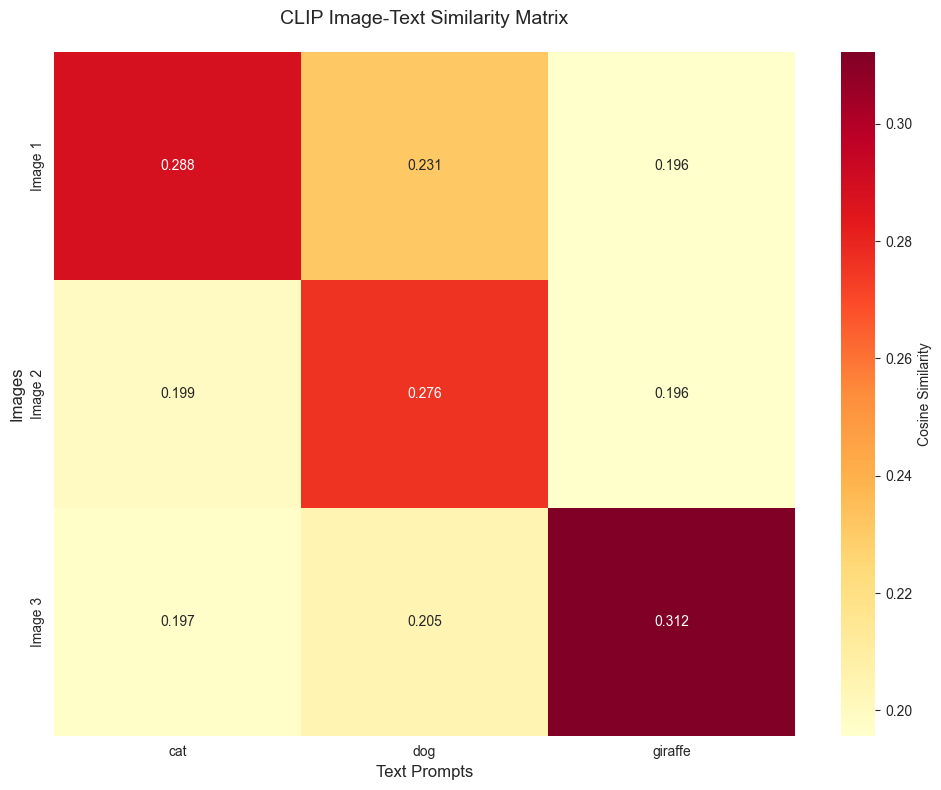


BEST MATCHES ANALYSIS

Best text matches for each image:
Image 1 → 'a photo of a cat' (similarity: 0.288)
Image 2 → 'a photo of a dog' (similarity: 0.276)
Image 3 → 'a photo of a giraffe' (similarity: 0.312)

Best image matches for each text:
'a photo of a cat' → Image 1 (similarity: 0.288)
'a photo of a dog' → Image 2 (similarity: 0.276)
'a photo of a giraffe' → Image 3 (similarity: 0.312)


In [9]:

print("\n" + "=" * 50)
print("c. COMPUTING COSINE SIMILARITIES")
print("=" * 50)

# Compute similarity matrix
similarity_matrix = (image_features @ text_features.T).cpu().numpy()

print("Similarity Matrix:")
print("Rows = Images, Columns = Text Prompts")
print("=" * 60)
for i, prompt in enumerate(text_prompts):
    print(f"{prompt:25}", end="")
print()
for i in range(len(images)):
    print(f"Image {i + 1}:", end=" ")
    for j in range(len(text_prompts)):
        print(f"{similarity_matrix[i, j]:.3f}".ljust(10), end=" ")
    print()

# Visualize as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix,
            annot=True,
            fmt=".3f",
            xticklabels=[p.replace('a photo of a ', '') for p in text_prompts],
            yticklabels=[f'Image {i + 1}' for i in range(len(images))],
            cmap="YlOrRd",
            cbar_kws={'label': 'Cosine Similarity'})
plt.title("CLIP Image-Text Similarity Matrix", fontsize=14, pad=20)
plt.xlabel("Text Prompts", fontsize=12)
plt.ylabel("Images", fontsize=12)
plt.tight_layout()
plt.savefig('clip_similarity_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify best matches
print("\n" + "=" * 50)
print("BEST MATCHES ANALYSIS")
print("=" * 50)

print("\nBest text matches for each image:")
for i in range(len(images)):
    best_match_idx = np.argmax(similarity_matrix[i])
    best_similarity = similarity_matrix[i, best_match_idx]
    print(f"Image {i + 1} → '{text_prompts[best_match_idx]}' (similarity: {best_similarity:.3f})")

print("\nBest image matches for each text:")
for j in range(len(text_prompts)):
    best_match_idx = np.argmax(similarity_matrix[:, j])
    best_similarity = similarity_matrix[best_match_idx, j]
    print(f"'{text_prompts[j]}' → Image {best_match_idx + 1} (similarity: {best_similarity:.3f})")



In [ ]:
# d Implement and analyze InfoNCE Loss


print("\n" + "=" * 50)
print("d. EXTRA: INFO-NCE LOSS ANALYSIS")
print("=" * 50)


def info_nce_loss(image_features, text_features, temperature=0.07):
    """
    Compute the symmetric InfoNCE loss used in CLIP training
    """
    # Cosine similarities scaled by temperature
    logits = (image_features @ text_features.T) / temperature

    # Labels: diagonal elements are positive pairs
    batch_size = logits.shape[0]
    labels = torch.arange(batch_size).to(logits.device)

    # Symmetric loss (image-to-text + text-to-image)
    loss_i = F.cross_entropy(logits, labels)  # Image predicting text
    loss_t = F.cross_entropy(logits.T, labels)  # Text predicting image
    loss = (loss_i + loss_t) / 2

    return loss, logits


# Test with different temperature values
temperatures = [0.01, 0.07, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
losses = []

print("\nInfoNCE Loss vs Temperature:")
print("Temperature\tLoss\t\tDescription")
print("-" * 50)

for temp in temperatures:
    loss, logits = info_nce_loss(image_features, text_features, temperature=temp)
    losses.append(loss.item())

    # Describe the effect
    if temp < 0.1:
        desc = "Very low - sharp distribution"
    elif temp < 1.0:
        desc = "CLIP default range"
    elif temp < 5.0:
        desc = "Moderate smoothing"
    else:
        desc = "High - uniform distribution"

    print(f"{temp:>10.2f}\t{loss.item():.4f}\t\t{desc}")

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.plot(temperatures, losses, 'bo-', linewidth=2, markersize=8, markerfacecolor='red')
plt.xscale('log')
plt.xlabel('Temperature (τ) - Log Scale', fontsize=12)
plt.ylabel('InfoNCE Loss', fontsize=12)
plt.title('Effect of Temperature on InfoNCE Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('info_nce_temperature.png', dpi=300, bbox_inches='tight')
plt.show()

# Show probability distributions for different temperatures
print("\n" + "=" * 50)
print("PROBABILITY DISTRIBUTIONS")
print("=" * 50)

image_idx = 0  # First image (cat)
print(f"\nProbability distribution for Image 1 across different temperatures:")
print("Text Prompts:", [p.replace('a photo of a ', '') for p in text_prompts])

for temp in [0.07, 1.0, 5.0]:
    with torch.no_grad():
        logits = (image_features[image_idx:image_idx + 1] @ text_features.T) / temp
        probs = F.softmax(logits, dim=-1).cpu().numpy()[0]

    print(f"\nTemperature {temp}:")
    for j, prompt in enumerate(text_prompts):
        short_prompt = prompt.replace('a photo of a ', '')
        print(f"  {short_prompt:15}: {probs[j]:.3f} ({probs[j] * 100:.1f}%)")

print("\n" + "=" * 50)
print("SUMMARY")
print("=" * 50)
print("✓ CLIP model successfully loaded and tested")
print("✓ Images and text encoded with L2 normalization")
print("✓ Cosine similarities computed and visualized")
print("✓ InfoNCE loss implemented and analyzed")
print("✓ Expected: Diagonal elements should have highest similarity")
print(f"✓ Results saved: 'clip_similarity_matrix.png' and 'info_nce_temperature.png'")